# Setup

In [ ]:
#download de biblioteca para dividir a pasta de treino entre validação e treino
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importações nativas
import os
import glob
import shutil
import random

#setup
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, regularizers, initializers
from keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import Image as display_image
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

import splitfolders

# Carga de dados

In [ ]:
#biblioteca do kaggle para fazer o download das imagens
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#criando um diretorio para salvar os arquivos kaggle
!mkdir ~/.kaggle

In [ ]:
#salvando o json com as APIs do kaggle no diretório criado
! cp kaggle.json ~/.kaggle/

In [ ]:
#download das imagens
! kaggle datasets download nishantbansal01/bird-species-classification

 98% 1.03G/1.06G [00:09<00:00, 198MB/s]
100% 1.06G/1.06G [00:09<00:00, 122MB/s]


In [ ]:
#descompactando as pastas
!unzip -q bird-species-classification.zip

# Pre processamento

In [ ]:
#dividindo a base de Treino em treino e validação
splitfolders.ratio("./Train/", output="output",
                   seed=42, ratio=(.8, .2))

Copying files: 9414 files [00:02, 3195.36 files/s]


In [ ]:
#definindo alguns parâmetros do treinamento
IMG_SIZE = 300
BATCH_SIZE = 32

In [ ]:
# para o baseline, não faremos aumentação de dados
# OBS: NA HORA DE APLICAR AUMENTAÇÃO DE DADOS, FAZER APENAS NA BASE DE TREINO

train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function = preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    './output/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
)


valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
validation_generator = valid_datagen.flow_from_directory(
    './output/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)



test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    'Test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

Found 7445 images belonging to 200 classes.
Found 1969 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


# Modelagem

In [ ]:
#fazendo o download dos pesos imagenet da efficientnet B3
from tensorflow.keras.applications import EfficientNetB1
model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

27018416/27018416 [==============================] - 0s 0us/step


In [ ]:
#checando as camadas da efficient net
# model.summary()

In [ ]:
#congelando as camadas do modelo pretreinado
for layer in model.layers:
    layer.trainable = False

#adicionando o pooling e final e a camada output com a dimensão do nosso problema (200 classes)
# frozen_model = tf.keras.Sequential([
#   model,
#   tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Dense(200, activation="softmax")
# ])

# frozen_model.summary()



#usando a functional API para atender o gradCAM
pooling = tf.keras.layers.GlobalAveragePooling2D()(model.output)
dropout_layer = tf.keras.layers.Dropout(0.4)(pooling)
output_layer = tf.keras.layers.Dense(200, activation="softmax")(dropout_layer)
frozen_model = tf.keras.Model(model.input, output_layer)

# frozen_model.summary()

In [ ]:
# #checkpoint para salvar os melhores resultados
# cp_callback = tf.keras.callbacks.ModelCheckpoint('weights.h5',
#                                         save_best_only=True,
#                                         verbose=1)

#criando alguns callbacks para otimizar o treinamento e evitar epochs desnecessarias
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, min_delta=0.01),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=4)

]

In [ ]:
#compila o modelo
frozen_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])

# frozen_model.compile(
#     loss="categorical_crossentropy",
#     optimizer="adam",
#     metrics=["acc"],
# )

In [ ]:
#treinamento
%%time
frozen_model.fit(train_generator,
            epochs=30,
            batch_size=BATCH_SIZE,
            validation_data=validation_generator,
            callbacks=callbacks)

Epoch 1/30
233/233 [==============================] - 180s 707ms/step - loss: 3.9264 - acc: 0.2064 - val_loss: 2.6575 - val_acc: 0.4911 - lr: 0.0010
Epoch 2/30
233/233 [==============================] - 162s 696ms/step - loss: 2.3183 - acc: 0.4928 - val_loss: 1.8979 - val_acc: 0.6379 - lr: 0.0010
Epoch 3/30
233/233 [==============================] - 160s 686ms/step - loss: 1.7663 - acc: 0.5958 - val_loss: 1.5673 - val_acc: 0.6856 - lr: 0.0010
Epoch 4/30
233/233 [==============================] - 161s 692ms/step - loss: 1.4943 - acc: 0.6531 - val_loss: 1.3800 - val_acc: 0.7034 - lr: 0.0010
Epoch 5/30
233/233 [==============================] - 161s 689ms/step - loss: 1.3078 - acc: 0.6877 - val_loss: 1.2722 - val_acc: 0.7263 - lr: 0.0010
Epoch 6/30
233/233 [==============================] - 161s 692ms/step - loss: 1.1744 - acc: 0.7116 - val_loss: 1.1820 - val_acc: 0.7313 - lr: 0.0010
Epoch 7/30
233/233 [==============================] - 161s 692ms/step - loss: 1.0909 - acc: 0.7354 - val_l

In [ ]:
#salvando o modelo
frozen_model.save("efnetB1_frozenDenseReg_aug.h5")

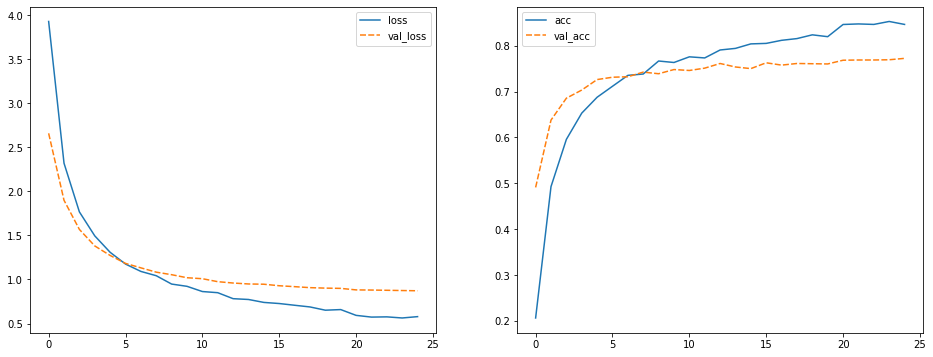

In [ ]:
#avaliação da evolução das curvas loss para analisar a qualidade do treinamento
history_f = pd.DataFrame(frozen_model.history.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history_f.loc[:25, ['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history_f.loc[:25, ['acc', 'val_acc']])

# Availando o modelo na base de validação

In [ ]:
#extraindo os valores das classes na base de validação
y_val = validation_generator.labels

In [ ]:
#gerando as predições na base de validação
y_pred = frozen_model.predict(validation_generator)

62/62 [==============================] - 10s 136ms/step


In [ ]:
#usando o evaluate para avaliar o modelo de acordo com as métricas definidas no treinamento
frozen_model.evaluate(validation_generator)

62/62 [==============================] - 9s 143ms/step - loss: 1.0821 - acc: 0.6948


[1.082122802734375, 0.6947689056396484]

In [ ]:
#transformando as probabilidades em classe
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
#cálculo da acurácia balanceada no conjunto de validação
from sklearn.metrics import accuracy_score

result = accuracy_score(y_val, y_pred)
print(f"Acurácia Balanceada - Efficient Net B3 baseline model: {result}")

Acurácia Balanceada - Efficient Net B3 baseline model: 0.6947689182326053


# Availando o modelo na base de testes

In [ ]:
#extraindo os valores das classes na base de testes
y_test = test_generator.labels

In [ ]:
#gerando as predições na base de testes
y_pred = frozen_model.predict(test_generator)

75/75 [==============================] - 14s 164ms/step


In [ ]:
#usando o evaluate para avaliar o modelo de acordo com as métricas definidas no treinamento
frozen_model.evaluate(test_generator)

75/75 [==============================] - 12s 161ms/step - loss: 0.8126 - acc: 0.7835


[0.8125672340393066, 0.7834877967834473]

In [ ]:
#transformando as probabilidades em classe
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
#cálculo da acurácia balanceada na base de testes
result = accuracy_score(y_test, y_pred)
print(f"Acurácia Balanceada na base de testes - Efficient Net B3 baseline model: {result}")

Acurácia Balanceada na base de testes - Efficient Net B3 baseline model: 0.7834877843302444


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.28      0.58      0.38        12
           2       1.00      1.00      1.00        12
           3       0.92      0.92      0.92        12
           4       0.92      0.92      0.92        12
           5       1.00      0.90      0.95        10
           6       0.82      0.75      0.78        12
           7       0.46      0.50      0.48        12
           8       0.78      0.70      0.74        10
           9       0.73      0.92      0.81        12
          10       0.75      0.75      0.75        12
          11       0.85      0.92      0.88        12
          12       0.79      0.92      0.85        12
          13       0.75      0.75      0.75        12
          14       0.64      0.75      0.69        12
          15       0.89      0.67      0.76        12
          16       1.00      0.92      0.96        12
          17       0.92    

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.head()

,precision,recall,f1-score,support
0,0.545455,0.500000,0.521739,12.0
1,0.280000,0.583333,0.378378,12.0
2,0.923077,1.000000,0.960000,12.0
3,0.857143,1.000000,0.923077,12.0
4,0.785714,0.916667,0.846154,12.0


In [ ]:
df_report = df_report.reset_index()
df_report.columns = ["class", "precision", "recall", "f1-score", "support"]

In [ ]:
df_report.head()

,class,precision,recall,f1-score,support
0,0,0.545455,0.500000,0.521739,12.0
1,1,0.280000,0.583333,0.378378,12.0
2,2,0.923077,1.000000,0.960000,12.0
3,3,0.857143,1.000000,0.923077,12.0
4,4,0.785714,0.916667,0.846154,12.0


In [ ]:
df_report.tail()

,class,precision,recall,f1-score,support
198,198,1.000000,0.833333,0.909091,12.000000
199,199,0.750000,0.500000,0.600000,12.000000
200,accuracy,0.783488,0.783488,0.783488,0.783488
201,macro avg,0.796746,0.784270,0.782478,2374.000000
202,weighted avg,0.795718,0.783488,0.781509,2374.000000


In [ ]:
df_report = df_report.iloc[0:200, :]
df_report.tail()

,class,precision,recall,f1-score,support
195,195,0.666667,0.333333,0.444444,12.0
196,196,0.625000,0.833333,0.714286,12.0
197,197,0.833333,0.833333,0.833333,12.0
198,198,1.000000,0.833333,0.909091,12.0
199,199,0.750000,0.500000,0.600000,12.0


In [ ]:
label_map = (train_generator.class_indices)

In [ ]:
type(label_map)

dict

In [ ]:
species = label_map.keys()
classes = label_map.values()

In [ ]:
df_labels = pd.DataFrame({"species": species,
                          "class": classes})

df_labels.head()

,species,class
0,Acadian_Flycatcher,0
1,American_Crow,1
2,American_Goldfinch,2
3,American_Pipit,3
4,American_Redstart,4


In [ ]:
df_report["class"] = df_report["class"].astype("int")
df_labels["class"] = df_labels["class"].astype("int")

df_report = df_report.merge(df_labels, on="class", how="left")
df_report.head()

,class,precision,recall,f1-score,support,species
0,0,0.545455,0.500000,0.521739,12.0,Acadian_Flycatcher
1,1,0.280000,0.583333,0.378378,12.0,American_Crow
2,2,0.923077,1.000000,0.960000,12.0,American_Goldfinch
3,3,0.857143,1.000000,0.923077,12.0,American_Pipit
4,4,0.785714,0.916667,0.846154,12.0,American_Redstart


In [ ]:
df_report.to_csv("report_effnetB1.csv", index=False)

In [ ]:
df_report_precision = df_report.sort_values(by="precision", ascending=True)
df_report_precision.head()

,class,precision,recall,f1-score,support,species
64,64,0.200000,0.083333,0.117647,12.0,Fish_Crow
53,53,0.214286,0.250000,0.230769,12.0,Common_Tern
172,172,0.250000,0.166667,0.200000,12.0,Tennessee_Warbler
87,87,0.266667,0.333333,0.296296,12.0,Herring_Gull
1,1,0.280000,0.583333,0.378378,12.0,American_Crow


In [ ]:
df_report_recall = df_report.sort_values(by="recall", ascending=True)
df_report_recall.head()

,class,precision,recall,f1-score,support,species
64,64,0.200000,0.083333,0.117647,12.0,Fish_Crow
172,172,0.250000,0.166667,0.200000,12.0,Tennessee_Warbler
53,53,0.214286,0.250000,0.230769,12.0,Common_Tern
66,66,0.600000,0.250000,0.352941,12.0,Forsters_Tern
113,113,0.444444,0.333333,0.380952,12.0,Mockingbird


# Interpretabilidade

### GRAD-CAM

In [ ]:
def get_img_array(img_path, size):
    '''
    Transforma a imagem em um tensor!
    ARGS:
    img_path <- string contendo o caminho da imagem
    size <- tupla com dois inteiros
    RETURN:
    array <- np.array
    '''
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    '''
    img_array <- np.array da imagem
    model <- objeto do modelo
    last_conv_layer_name <- nome da ultima layer de convolução (str)
    pred_index <- int - index da predição
    '''
    # Primeiro, criamos um modelo que mapeia a imagem de entrada para as ativações
    # da última camada de convolução, bem como as previsões de saída.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    # Em seguida, calculamos o gradiente da classe predita (com maior probabildiade)
    # para nossa imagem de entrada com relação às ativações da última camada de convolução
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradiente do output do neurônio de saida em relação ao mapa de feature da ultima
    #camada de convolução
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vetor para cada entrada é a média da intensidade do gradiente
    # em relação ao mapa de feature
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    # Multiplicamos cada canal na matriz do mapa de features
    # pelo gradiente (importância do canal) em relação à classe predita com maior probabilidade
    # então soma-se os canais para obter a ativação da classe do mapa de calor
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizando entre 0 e 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    '''
    Salva e realiza a exibição do gradiente em relação a imagem (sobreposição)
    ARGS:
    img_path <- caminho da imagem (str)
    heatmap <- mapa de calor numpy (np.array)
    cam_path < argumento para salvar a imagem
    alpha = ajuste de transparência
    RETURN:
    imagem sobreposta(apenas display)
    '''

    # imagem original
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # rescalando a imagem entre até 255
    heatmap = np.uint8(255 * heatmap)

    # jet para colorizar o "gradiente"
    jet = cm.get_cmap("jet")

    # usando os valores RGB do heatmap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Criando uma imagem com RGB colorido com o heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Sobreposição das imagens
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Salvando a imagem para realizar o display
    superimposed_img.save(cam_path)

    # Display
    display(display_image(cam_path))
    # Excluí a imagem do caminho salvo
    os.remove(cam_path)

In [ ]:
species = list(species)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/Fish_Crow/Fish_Crow_0017_26127.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 26ms/step
Classe predita:  Common_Raven
probabilidade da predição 50.135213136672974


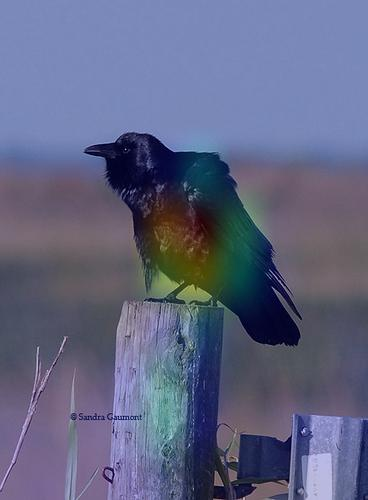

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/Fish_Crow/Fish_Crow_0031_25909.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 28ms/step
Classe predita:  Common_Raven
probabilidade da predição 64.93017673492432


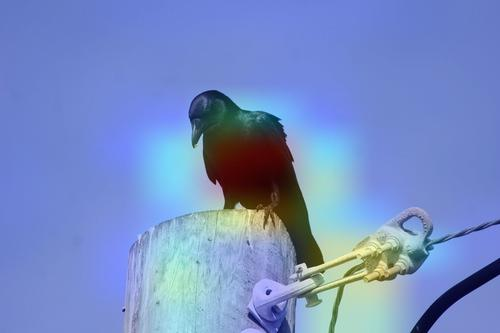

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/Fish_Crow/Fish_Crow_0049_26040.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 27ms/step
Classe predita:  American_Crow
probabilidade da predição 28.49760353565216


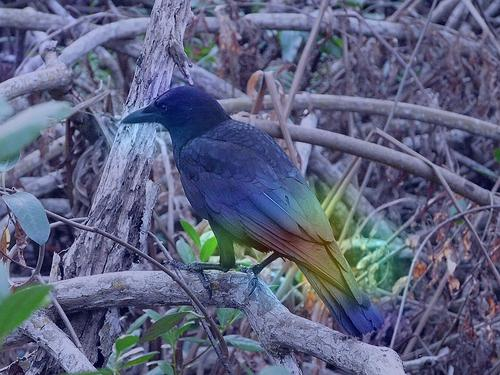

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/Common_Raven/Common_Raven_0017_102044.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 27ms/step
Classe predita:  American_Crow
probabilidade da predição 53.80864143371582


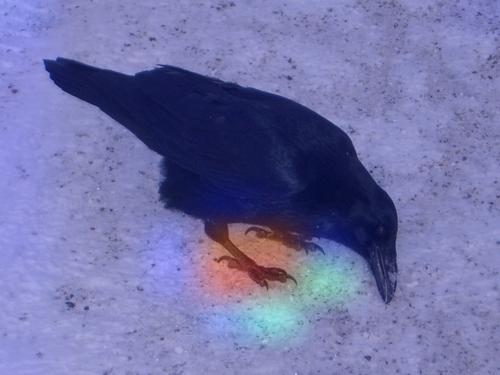

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/Common_Raven/Common_Raven_0036_102025.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 26ms/step
Classe predita:  Common_Raven
probabilidade da predição 66.0132110118866


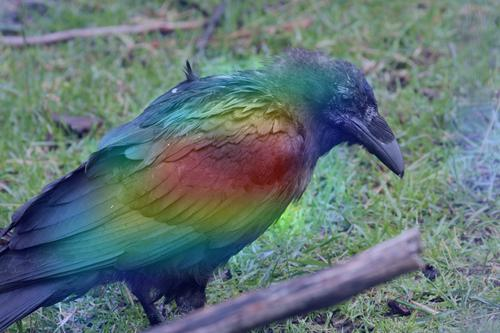

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/Common_Raven/Common_Raven_0085_102041.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 25ms/step
Classe predita:  Common_Raven
probabilidade da predição 79.83777523040771


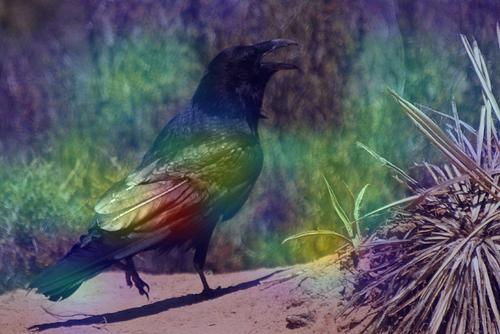

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/American_Crow/American_Crow_0016_25112.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 26ms/step
Classe predita:  American_Crow
probabilidade da predição 41.340264678001404


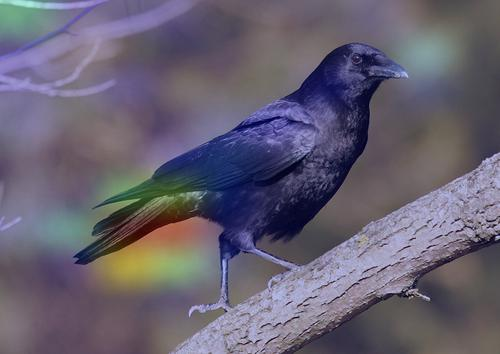

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)

In [ ]:
#fazendo download de uma imagem e armazenando.
img_path = "/content/Test/American_Crow/American_Crow_0062_25587.jpg"

# display(display_image(img_path))

# preparando imagem
img_array = preprocess_input(get_img_array(img_path, size=(300,300)))

# predição
pred = frozen_model.predict(img_array)
print('Classe predita: ', species[np.argmax(pred)])
print('probabilidade da predição', pred[0][np.argmax(pred)] * 100)

1/1 [==============================] - 0s 26ms/step
Classe predita:  American_Crow
probabilidade da predição 45.11042833328247


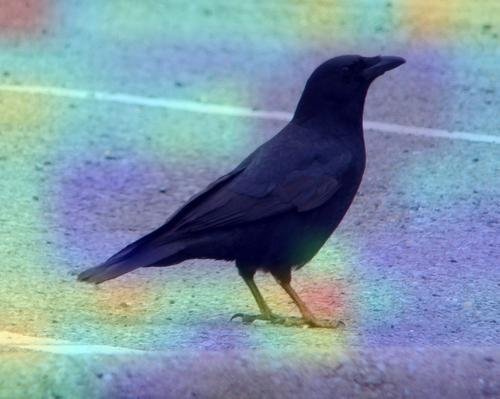

In [ ]:
#extraindo o mapa de features ("calor") e sobrepondo a imagem original.
heatmap = make_gradcam_heatmap(img_array, frozen_model, 'top_conv', pred_index=np.argmax(pred))
save_and_display_gradcam(img_path, heatmap)